# H-Scan Prototype

### Packages and Functions

In [1]:
import sys, os
import re
from pathlib import Path
import platform

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

from scipy.signal import hilbert, get_window, welch, savgol_filter, medfilt
from scipy.fft import fft, fftfreq, fftshift, ifft, ifftshift
from scipy.io import loadmat, savemat

import yaml

import ipywidgets as widgets
from ipywidgets import interact

# read rf data
def read_rf(filename):
    hdr_info = ('id', 'frames', 'lines', 'samples', 'samplesize')
    hdr, timestamps, data = {}, None, None
    with open(filename, 'rb') as raw_bytes:
        # read 4 bytes header 
        for info in hdr_info:
            hdr[info] = int.from_bytes(raw_bytes.read(4), byteorder='little')
        # read timestamps and data
        timestamps = np.zeros(hdr['frames'], dtype='int64')
        sz = hdr['lines'] * hdr['samples'] * hdr['samplesize']
        data = np.zeros((hdr['lines'], hdr['samples'], hdr['frames']), dtype='int16')
        for frame in range(hdr['frames']):
            # read 8 bytes of timestamp
            timestamps[frame] = int.from_bytes(raw_bytes.read(8), byteorder='little')
            # read each frame
            data[:, :, frame] = np.frombuffer(raw_bytes.read(sz), dtype='int16').reshape([hdr['lines'], hdr['samples']])
    data =np.swapaxes(data,0,1)        
    print('Loaded {d[2]} raw frames of size, {d[0]} x {d[1]} (sampels x lines)'.format(d=data.shape))
    return hdr, timestamps, data

# read env data
def read_env(filename):
    hdr_info = ('id', 'frames', 'lines', 'samples', 'samplesize')
    hdr, timestamps, data = {}, None, None
    with open(filename, 'rb') as raw_bytes:
        # read 4 bytes header 
        for info in hdr_info:
            hdr[info] = int.from_bytes(raw_bytes.read(4), byteorder='little')
        # read timestamps and data
        timestamps = np.zeros(hdr['frames'], dtype='int64')
        sz = hdr['lines'] * hdr['samples'] * hdr['samplesize']
        data = np.zeros((hdr['lines'], hdr['samples'], hdr['frames']), dtype='uint8')
        for frame in range(hdr['frames']):
            # read 8 bytes of timestamp
            timestamps[frame] = int.from_bytes(raw_bytes.read(8), byteorder='little')
            # read each frame
            data[:, :, frame] = np.frombuffer(raw_bytes.read(sz), dtype='uint8').reshape([hdr['lines'], hdr['samples']])
    print('Loaded {d[2]} raw frames of size, {d[0]} x {d[1]} (lines x samples)'.format(d=data.shape))
    return hdr, timestamps, data

def rf_2_bmode(rf_data, dynamic_range=50, convert_to_8_bit=False):
    """
    Hisham Assi 2025 (hisham.assi@alumni.utoronto.ca)
    Apply gamma log compression (link below) while incorporating the db dynamic range commonin medical ultrasound 
    https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_LogCompression.html

    Args:
    rf_data (np.ndarray): Input RF data
    dynamic_range (float): Dynamic range in dB
    convert_to_8_bit (bool): Whether to convert to 8-bit
        
    Returns:
        np.ndarray: B-mode image
    """
    # Envelope detection using Hilbert transform
    analytic_signal = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic_signal)
    M = np.max(envelope)
    A = 10**(dynamic_range/20) - 1
    bmode = np.log10(1 + A * (envelope/M))/np.log10(1+A)

    # Convert to 8-bit grayscale
    if convert_to_8_bit:
        bmode = (255 * bmode).astype(np.uint8) 
    
    return bmode

#Log compression from k-wave
def rf_to_bomode_gamma(rf_data, gamma=1, normalise=1):
    """
    Hisham Assi 2025
    """
    # 1. Envelope detection using Hilbert transform
    def envelope_detection(signal, axis=0):
        return np.abs(hilbert(signal, axis=0))
    # 2. gamma Log compression
    def gamma_log_compress(signal, gamma=1, normalise=1):
        """
        Hisham Assi 2025
        Apply gamma log compression to the input signal:
        https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_LogCompression.html
        
        The larger the gamma, the larger the resulting compression
        This function is similar to k-wave's logCompression MATLAB function
        """
        mx = np.max(signal)
        if normalise == 0: # No normalisation
            return np.log10(1 + gamma * signal) 
        elif normalise == 1: # Normalise to [0, 1]
            return np.log10(1 + gamma * (signal / mx)) / np.log10(1 + gamma)
        elif normalise == 2: # Normalise to [0, mx]
            return mx * (np.log10(1 + gamma * (signal / mx)) / np.log10(1 + gamma))
        
    bmode = gamma_log_compress(envelope_detection(rf_data), gamma=gamma, normalise=normalise)
    return bmode
    
def rf_to_bmode(rf_data, dynamic_range=60, convert_to_8_bit=False):
    """
    Hisham Assi 2025
    Convert RF data to B-mode image using the dB method common in ultrasound.
    """
    # 1. Envelope detection using Hilbert transform
    analytic_signal = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic_signal)

    # 2. Log compression to reduce dynamic range
    # Normalize to [0, 1] and avoid log(0)
    envelope_normalized = envelope / envelope.max()
    epsilon = 1e-13  # Small value to prevent log(0)
    bmode = 20 * np.log10(envelope_normalized + epsilon)
    
    # 3. Dynamic range adjustment
    bmode -= bmode.max()
    bmode = np.clip(bmode, -dynamic_range, 0)
    bmode += dynamic_range
    bmode /= dynamic_range  # Normalize to [0, 1]
    
    # 4. Convert to 8-bit grayscale
    if convert_to_8_bit:
        bmode = (255 * bmode).astype(np.uint8)
    
    return bmode

def signal_fft(rf_signal, fs, Nfft, window_type='hamming', dimentions=1, shift = False):
    """
    Hisham Assi 2025
    Compute the spectrum and its power for each RF line along axis 0 with windowing and zero-padding.
    Simalar to Matlab sig_fft from Eno's
    Parameters:
    frame_rf (numpy.ndarray): The RF data array.
    fs (float): The sampling frequency in Hz.
    Nfft (int): The number of FFT points.
    window_type (str): The type of window to apply (default is 'hamming').
    
    Returns:
    freqs (numpy.ndarray): The frequency bins.
    spectrum (numpy.ndarray): The spectrum of the RF data.
    power (numpy.ndarray): The power of the RF data.
    """
    # Get annd apply the window function if needed

    if window_type == 'none':
        windowed_rf = rf_signal
    else:
        window = get_window(window_type, rf_signal.shape[0])
        
        if dimentions == 1:
            # Apply the window function to the RF line
            windowed_rf = rf_signal * window
        elif dimentions == 2:
            # Apply the window function to the RF line
            windowed_rf = rf_signal * window[:, np.newaxis]

    # Compute the FFT along axis 0 and Frequency bins
    spectrum = fft(windowed_rf, n=Nfft, axis=0)
    freqs = fftshift(fftfreq(Nfft, d=1/fs)) # non-shifted freqs are not helpful

    # Shift the zero frequency to the center if needed
    if shift:
        spectrum = fftshift(spectrum, axes=0)
    
    # Compute the power
    power = np.abs(spectrum) ** 2
    power_db = 10 * np.log10(power/np.max(power))
    
    return freqs, spectrum, power_db

def find_patient_folder(path, patient_id):
    """Finds a folder in the given path that starts with 'P' followed by the patient_id."""
    pattern = rf"{patient_id}" if isinstance(patient_id, str) else rf"^P{patient_id}"  # Use patient_id directly if it's a string, otherwise construct the regex pattern
    #pattern = patient_id
    try:
        for folder in os.listdir(path):
            if os.path.isdir(os.path.join(path, folder)) and re.search(pattern, folder):
                return os.path.join(path, folder)  # Return the first matching folder name
    
    except FileNotFoundError:
        print(f"Error: The directory '{path}' does not exist.")
        return None
    
    return None  # Return None if no matching folder is found

def find_image_folder(path, patient_id, image_id):
    """Finds a folder in the given patient_dir that starts with 'P{patient_id}_Image_{image_id}'."""
    patient_dir = find_patient_folder(path, patient_id)

    print(f"Patient directory: {patient_dir}")
    
    #pattern = rf"^P{patient_id}_Image_{image_id}"  # Regex pattern to match 'P{patient_id}_Image_{image_id}' at the start
    pattern = rf"{image_id}" if isinstance(patient_id, str) else rf".*Image_{image_id}$|.*image_{image_id}$"  # Regex pattern to match any name ending with 'Image_{image_id}' or 'image_{image_id}'

    try:
        for folder in os.listdir(patient_dir):
            if os.path.isdir(os.path.join(patient_dir, folder)) and re.match(pattern, folder):
                return os.path.join(patient_dir, folder)  # Return the first matching folder name
    
    except FileNotFoundError:
        print(f"Error: The directory '{patient_dir}' does not exist.")
        return None
    
    return None  # Return None if no matching folder is foun



def find_image_file(image_dir,file_extension ='rf.raw'):
    """Finds a file in the given image_dir that ends with file_extension."""
    try:
        for file in os.listdir(image_dir):
            if file.endswith(file_extension):
                return os.path.join(image_dir, file) # Return the first matching file name
    
    except FileNotFoundError:
        print(f"Error: The directory '{image_dir}' does not exist.")
        return None
    
    return None  # Return None if no matching file is found

def number_from_string(s):
    return float(re.search(r"\d+\.?\d*", s).group())

def mask_nan(input, mask):
    """
    Hisham Assi 2025 hisham.assi@utoronto.ca
    Apply a mask to the input array and replace values where the mask is 0 with NaN.

    Parameters:
    input (numpy.ndarray): The input array.
    mask (numpy.ndarray): The mask array.

    Returns:
    numpy.ndarray: The masked input array with NaN values.
    """
    if not np.issubdtype(input.dtype, np.floating):
        input = input.astype(float)  # Convert to float to support NaN
    masked_input = input.copy()
    masked_input[mask == 0] = np.nan  # Replace values where mask is 0 with NaN
    return masked_input

def moving_average_smoothing(x, window_size):
    window = np.ones(window_size)/window_size
    return np.convolve(x, window, mode='same')

def smooth_spectrum(spectrum, FLT=1, WIN_LEN=111, poly_order=2):
    """
    Hisham Assi 2025 hisham.assi@utoronto.ca

    Apply smoothing to a spectrum using a selected filter type.
    Supports Savitzky-Golay, median, and moving average filters.

    Parameters:
        spectrum (np.ndarray): Input spectrum (real or complex).
        WIN_LEN (int): Length of the smoothing window (must be odd).
        poly_order (int): Polynomial order for Savitzky-Golay filter.
        FLT (int): Filter type:
            1 - Savitzky-Golay
            2 - Median filter
            3 - Moving average

    Returns:
        np.ndarray: Smoothed spectrum.
    """
    if not isinstance(spectrum, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if WIN_LEN % 2 == 0 or WIN_LEN < 1:
        raise ValueError("WIN_LEN must be a positive odd integer.")
    if FLT == 1 and poly_order >= WIN_LEN:
        raise ValueError("poly_order must be less than WIN_LEN.")

    def apply_filter(data):
        if FLT == 1:
            return savgol_filter(data, WIN_LEN, poly_order)
        elif FLT == 2:
            return medfilt(data, WIN_LEN)
        elif FLT == 3:
            kernel = np.ones(WIN_LEN) / WIN_LEN
            return np.convolve(data, kernel, mode='same')
        else:
            raise ValueError("Unsupported filter type. Use 1, 2, or 3.")

    if np.iscomplexobj(spectrum):
        return apply_filter(spectrum.real) + 1j * apply_filter(spectrum.imag)
    else:
        return apply_filter(spectrum)
    

# Compute instantaneous frequencies using the gradient of the unwrapped phase
def compute_instantaneous_frequencies(data_2d, fs, method='gradient'):
    """
    Hisham Assi 2025
    Compute instantaneous frequencies for all columns in a 2D array using either:
    - Gradient of unwrapped phase (default)
    - Complex conjugate multiplication (with NaN at first sample)
    
    Args:
        data_2d (np.ndarray): 2D array of shape (n_samples, n_signals)
        fs (float): Sampling frequency in Hz
        method (str): 'gradient' or 'complex' (default: 'gradient')
        
    Returns:
        np.ndarray: 2D array of instantaneous frequencies with same shape as input
    """
    if method not in ['gradient', 'complex']:
        raise ValueError("Method must be 'gradient' or 'complex'")
    
    n_samples, n_signals = data_2d.shape
    result = np.zeros_like(data_2d) if method == 'gradient' else np.full_like(data_2d, np.nan)
    
    for col in range(n_signals):
        signal = data_2d[:, col]
        analytic_signal = hilbert(signal)
        
        
        if method == 'gradient':
            phase = np.unwrap(np.angle(analytic_signal))
            phase = savgol_filter(phase, window_length=33, polyorder=2)
            result[:, col] = np.gradient(phase, 1/fs) / (2 * np.pi)
            
        elif method == 'complex':
            phase_diffs = np.angle(analytic_signal[1:] * np.conj(analytic_signal[:-1]))
            result[1:, col] = (phase_diffs * fs) / (2 * np.pi)
    
    return result

def compute_2d_instantaneous_frequency(frame_rf, fs, win_leng=55):
    """
    Hisham Assi 2025
    Compute the instantaneous frequency for all columns in frame_rf.

    Parameters:
    frame_rf (numpy.ndarray): 2D array of RF data (samples x lines).
    fs (float): Sampling frequency in Hz.

    Returns:
    numpy.ndarray: 2D array of instantaneous frequencies (samples x lines).
    """
    n_samples, n_signals = frame_rf.shape
    fin_2d = np.zeros((n_samples, n_signals))  # Initialize the 2D array

    for ll in range(n_signals):
        signal = frame_rf[:, ll]
        analytic_signal = hilbert(signal)
        phase = np.unwrap(np.angle(analytic_signal))
        phase = savgol_filter(phase, window_length=win_leng, polyorder=2)
        fin_2d[:, ll] = np.gradient(phase, 1 / fs) / (2 * np.pi)

    return fin_2d

#Matched filter design
def gaussian_cos_filter(f, fm, sigma, n):
    gc = np.exp(- (f - fm[n])**2 / (2 * sigma**2)) + np.exp(- (f + fm[n])**2 / (2 * sigma**2))
    gc = ifftshift(gc)
    return gc


########### COLOR MAP ############
# create and save hscan colormap to the matplotlib
def generate_colormap( dim=1):
    colors = np.zeros((256, 3))  # 256 colors, 3 channels (R, G, B)
    
    # First half: Red to Black
    for i in range(128):
        colors[i] = [1 - dim*i / 128, 0, 0]  # Decrease Red
    #print(colors[128][0])
    
    # Second half: Black to Blue
    for i in range(128, 256):
        colors[i] = [0, 0, colors[255-i][0]]  # Increase Blue
    #print(colors[128][2])

    return mcolors.ListedColormap(colors, name="hscan")

# Generate and register the colormap
hscan = generate_colormap(4/5)
hscan

def generate_hscan(frame_rf, fs=15e6, fc=2.5e6, bw_fc=0.6, sigma=0.3e6, N=256):
    """
    Generate H-Scan color index from RF data without using signal_fft or gaussian_cos_filter.
    All calculations are done from scratch inside this function.

    Parameters:
        frame_rf (numpy.ndarray): 2D array of RF data (samples x lines).
        fs (float): Sampling frequency in Hz.
        fc (float): Center frequency in Hz.
        bw_fc (float): Bandwidth fraction of the center frequency.
        sigma (float): Standard deviation for Gaussian filter in Hz.
        N (int): Number of filters to apply.

    Returns:
        numpy.ndarray: H-Scan color index (samples x lines, dtype=np.uint8).
    """

    samples, lines = frame_rf.shape
    Nfft = 2 ** int(np.ceil(np.log2(samples)))
    f = fftfreq(Nfft, d=1/fs)
    fm = np.linspace((1-bw_fc)*fc, (1+bw_fc)*fc, N)

    color_index = np.zeros((samples, lines), dtype=np.uint8)

    for line in range(lines):
        rf_line = frame_rf[:, line]
        # Apply Hamming window before FFT
        window = np.hamming(len(rf_line))
        rf_line = rf_line * window
        
        # Compute the FFT of the RF line
        line_ft = fft(rf_line, n=Nfft)

        filtered_rf_line = np.zeros((samples, N))
        for n in range(N):
            gc = np.exp(- (f - fm[n])**2 / (2 * sigma**2)) + np.exp(- (f + fm[n])**2 / (2 * sigma**2))
            filtered_ft = line_ft * gc
    
            filtered_rf_line[:, n] = np.real(ifft(filtered_ft))[:samples]

        filtered_env_line = np.abs(hilbert(filtered_rf_line, axis=0))
        color_index[:, line] = np.argmax(filtered_env_line, axis=1).astype(np.uint8)

    return color_index


### Settings

In [2]:
#IS_REAL_PATIENT = 1 # True if the patient is real (not a phantom)
frame = -1 # last frame

frame_averaging = False

line_averaging = False # line averaging for (2*NL) central rf
NL = 3 # number of lines to average = 2*NL
# if no averaging is needed select the line you want to analyze
LINE = 95

sos = 1540

sigma = 0.3e6

bw_fc = 0.6 # sweep between -bw_fc% to bw_fc% of the center frequency

IS_FC_F0 = 0 # True if the central matching filter (in hscan) is the transmit frequency
FC = 2.5e6 # center matching filter frequency in Hz ( if not using the transmit frequency)

is_there_a_mask = 1 # True if there is a mask to apply to the data

frequency_smoothnig = False
WIN_LEN = 111 # window length for smoothing
PLY_ORD = 2 # polynomial order for smoothing

FLT = 1 #filter type
# 1 Apply Savitzky-Golay filter for smoothing
# 2 Apply median filter for smoothing
# 3 Apply moving average filter for smoothing

NFFT_MULT = 2 # number of points for FFT= NNFT_MULT * Nfft

ROI_RECT = 0 # True if you want to select a ROI rectangle for the analysis
if ROI_RECT:
    RC = [200, 2300, 45,150 ] # ROI rectangle [y1, y2, x1, x2] in pixels
    #RC = [600, 1500, 65,125 ] # ROI rectangle [y1, y2, x1, x2] in pixels
    #RC = [1000, 2500, 45,145 ] # ROI rectangle [y1, y2, x1, x2] in pixels (quartz L15)
    NFFT_MULT = 1
    LINE = int(((RC[3] - RC[2]) / 2) - 1) # line to analyze



In [3]:
def find_patient_folder(path, patient_id, visit_type, visit_id):
    """Finds a folder in the given path that starts with 'P' followed by the patient_id."""
    #pattern = rf"{patient_id}" if isinstance(patient_id, str) else rf"^P{patient_id}"  # Use patient_id directly if it's a string, otherwise construct the regex pattern
    #pattern = patient_id
    # Create regex pattern
    pattern = re.compile(rf"^P{patient_id}_{visit_type}_0{visit_id}_.+")   
    try:
        for folder in os.listdir(path):
            if os.path.isdir(os.path.join(path, folder)) and re.search(pattern, folder):
                return os.path.join(path, folder)  # Return the first matching folder name
    
    except FileNotFoundError:
        print(f"Error: The directory '{path}' does not exist.")
        return None
    
    return None  # Return None if no matching folder is found

def find_image_folder(path, patient_id, visit_type, visit_id, image_id):
    """Finds a folder in the given patient_dir that starts with 'P{patient_id}_Image_{image_id}'."""
    patient_dir = find_patient_folder(path, patient_id, visit_type, visit_id)

    print(f"Patient directory: {patient_dir}")
    
    #pattern = rf"^P{patient_id}_Image_{image_id}"  # Regex pattern to match 'P{patient_id}_Image_{image_id}' at the start
    pattern = rf"{image_id}" if isinstance(patient_id, str) else rf".*Image_{image_id}$|.*image_{image_id}$"  # Regex pattern to match any name ending with 'Image_{image_id}' or 'image_{image_id}'

    try:
        for folder in os.listdir(patient_dir):
            if os.path.isdir(os.path.join(patient_dir, folder)) and re.match(pattern, folder):
                return os.path.join(patient_dir, folder)  # Return the first matching folder name
    
    except FileNotFoundError:
        print(f"Error: The directory '{patient_dir}' does not exist.")
        return None
    
    return None  # Return None if no matching folder is foun

### Main

In [4]:
base_dir = "G:\\Shared drives\\TUPIL\\Dr. Hisham Assi - SMH RT\\data_ha"
#base_dir = Path("G:/Shared drives/TUPIL/Dr. Hisham Assi - SMH RT/data_ha")
#base_dir = Path("Z:/#POCUS KIDNEY TRIAL DATA/#POCUS DATA - Shared with TMU")
#base_dir = Path("Z:/#PANCREAS")
#base_dir = Path("Z:\#Neck_Flexion_Test") 


#patient_id = "Pancreas_L15_Research_4cm_20250528"
patient_id = 168 #"Neck_Flexion_Test_image 26"
visit_type = "PTONR" # visit type
visit_id = 1
#image_id = "image_1" # image number
image_id = 2 #"image_26" # image number    

image_dir = find_image_folder(base_dir, patient_id, visit_type, visit_id, image_id)
#image_name = os.path.basename(image_dir)

rf_file = find_image_file(image_dir)
yml_file = find_image_file(image_dir, 'rf.yml')

if is_there_a_mask:
    roi_file = find_image_file(os.path.join( image_dir, 'ROIs'), 'kidney.mat')

# Read the YAML parameters and compute the parameters that depend on them
with open(yml_file, "r") as file:
    yml_data = yaml.safe_load(file)
lines_number = yml_data['size']['number of lines']
samples_per_line = yml_data['size']['samples per line']
fs = number_from_string(yml_data['sampling rate'])*1e6
f0 = number_from_string(yml_data['transmit frequency'])*1e6
dt = 1/fs
t = np.arange(0, samples_per_line*dt, dt)
dz = sos*dt/2
z = 1e3 * np.arange(0, samples_per_line*dz, dz) #in mm
Nfft = 2 ** np.ceil(np.log(samples_per_line) / np.log(2))
Nfft = int(NFFT_MULT*Nfft)

# Read RF data
hdr, timestamps, data = read_rf(rf_file)

if frame_averaging:
    frame_rf = np.mean(data, axis=2)
else:
    frame_rf = data[:,:,frame]

bmode = rf_2_bmode(frame_rf, dynamic_range=50)

if ROI_RECT:
    frame_rf = frame_rf[RC[0]:RC[1], RC[2]:RC[3]] # [y1:y2, x1:x2]
    zz = z[RC[0]:RC[1]] # [y1:y2, x1:x2]
    xx = np.arange(RC[2], RC[3]) # [y1:y2, x1:x2]

#read ROI mask
if is_there_a_mask:
    roi_data = loadmat(roi_file)
    mask = roi_data["kidney_mask"]
    #mask = roi_data['kidney_mask']
else:
    mask = np.ones(frame_rf.shape)

alpha_mask = np.where(mask == 1, 1, 0.9)

if IS_FC_F0:
    fc = f0
else:
    fc = FC

# hscan_roi
#frame_rf = mask* frame_rf

Patient directory: G:\Shared drives\TUPIL\Dr. Hisham Assi - SMH RT\data_ha\P168_PTONR_01_May_30-24-REB16236-168
Loaded 18 raw frames of size, 2928 x 192 (sampels x lines)


In [ ]:
#plt.imshow(mask, aspect='auto', cmap='gray')
from skimage import measure
import cv2
# Find contours at a constant value of 0.5 (boundary between 0 and 1)
contours = measure.find_contours(mask, level=0.5)
# Plot result
plt.imshow(bmode, cmap='gray',aspect='auto')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
plt.title("Edge Line from Binary Mask")
plt.axis('off')
plt.show()

In [ ]:
dr = 70 #dB
A = rf_to_bmode(frame_rf, dr)
B = rf_2_bmode(frame_rf, dr)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Show B-mode image
axes[0].imshow(A, cmap='bone', aspect='auto')
axes[0].set_title('B-mode')
axes[0].set_xlabel('Line')
axes[0].set_ylabel('Sample')

# Show raw RF data
im = axes[1].imshow(B, aspect='auto', cmap='bone')
axes[1].set_title('Bmode_assi')
axes[1].set_xlabel('Line')
axes[1].set_ylabel('Sample')

plt.tight_layout()
# Add colorbars for both images
plt.colorbar(axes[0].images[0], ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
plt.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
plt.show()

bn =128
plt.figure(figsize=(10, 5))
plt.hist(A.flatten(), bins=bn, alpha=0.6, label='A', color='blue')
plt.hist(B.flatten(), bins=bn, alpha=0.6, label='B', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of A and B')
plt.legend()
plt.show()

### H-scan code

In [ ]:

fm = np.linspace((1-bw_fc)*fc, (1+bw_fc)*fc, 256)


#color_index = np.zeros(frame_rf.shape)
color_index = np.zeros(frame_rf.shape, dtype=np.uint8)
# f_mode will store the filtered RF lines for all lines and all 256 filters
f_mode = np.zeros((frame_rf.shape[0], frame_rf.shape[1], 256), dtype=float)

for line in range(frame_rf.shape[1]):
    rf_line = frame_rf[:, line]
        
    f, line_ft,_ = signal_fft(rf_line, fs, Nfft, window_type='hamming')
    # Smooth the spectrum if needed
    if frequency_smoothnig:
        line_ft = smooth_spectrum(line_ft, FLT=FLT, WIN_LEN=WIN_LEN)

    filtered_rf_line = np.zeros((len(rf_line), 256))  #, dtype=complex)

    # Apply each Gaussian filter and compute the inverse FFT
    for n in range(256):
        gaussian_cos = gaussian_cos_filter(f, fm, sigma,n)
        filtered_ft = line_ft * gaussian_cos
        filtered_rf_line[:,n] = np.real(ifft(filtered_ft)[:len(rf_line)]) #[:samples_per_line])

    filtered_env_line = np.abs(hilbert(filtered_rf_line, axis=0))
    f_mode[:, line, :] = filtered_env_line
    color_index[:,line] = np.argmax(filtered_env_line, axis=1)
f_mode/= np.max(f_mode)  # Normalize the filtered RF lines
f_mode = np.flip(f_mode, axis=0)  # Flip the array to match the original orientation

In [5]:
# Find the bounding rectangle (RR) that encapsulates the ROI (where mask == 1)
ys, xs = np.where(mask == 1)
y1, y2 = ys.min(), ys.max() + 1
x1, x2 = xs.min(), xs.max() + 1
RR = (y1, y2, x1, x2)

# Extract the rectangular region from frame_rf and mask
frame_rf_RR = frame_rf[y1:y2, x1:x2]
mask_RR = mask[y1:y2, x1:x2]
alpha_mask_RR = np.where(mask_RR == 1, 1, 0.5)
# Do processing on the rectangular region (e.g., generate H-scan)
#hscan_RR = generate_hscan(frame_rf_RR, fs, fc, bw_fc, sigma)
hscan_RR = generate_hscan(frame_rf_RR, fs, fc, bw_fc, sigma)

# Prepare an empty array for overlaying the processed image in its original location
#hscan_overlay= np.full_like(frame_rf, np.nan, dtype=float)  # dtype must be float for NaN
hscan_overlay = np.zeros_like(frame_rf, dtype=np.uint8)
hscan_overlay[y1:y2, x1:x2] = hscan_RR # * mask_RR.astype(np.uint8)
hscan_overlay_masked = mask_nan(hscan_overlay, mask)

(np.float64(-0.5), np.float64(175.5), np.float64(1322.5), np.float64(-0.5))

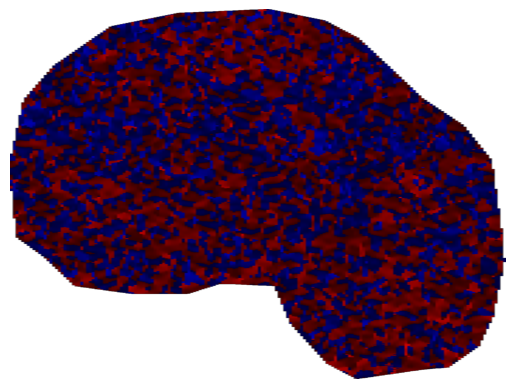

In [17]:
# # Prepare an empty array for overlaying the processed image in its original location
# hscan_overlay = np.nan*np.zeros_like(frame_rf)
# hscan_overlay[y1:y2, x1:x2] = hscan_RR # * mask_RR.astype(np.uint8)
# hscan_overlay.shape
# bmode.shape
np.min(hscan_RR)
plt.imshow(mask_nan(hscan_RR,mask_RR), aspect='auto', cmap=hscan, vmin=0, vmax=255)
#plt.imshow(hscan_overlay_masked, aspect='auto', cmap=hscan)
plt.axis('off')


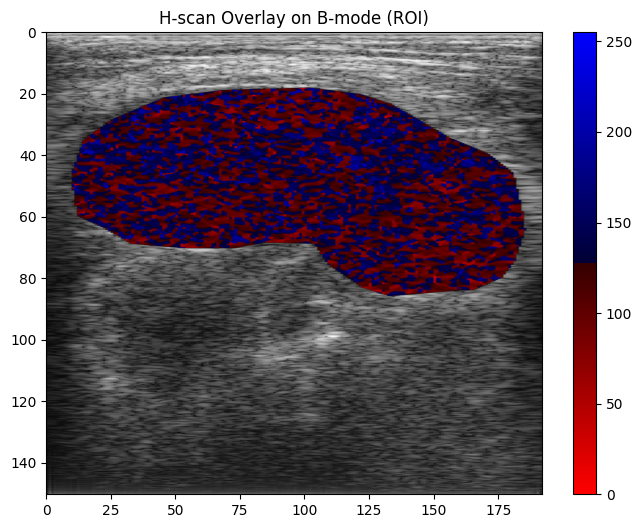

In [7]:
#alpha_mask_RR = np.where(mask_RR == 1, 1, 0.5)
plt.figure(figsize=(8, 6))
# Show the full B-mode image
plt.imshow(bmode, cmap='gray', aspect='auto', extent=[0, bmode.shape[1], z.max(), z.min()])
plt.imshow(hscan_overlay_masked, cmap=hscan, aspect='auto', vmin=0, vmax=255,
           extent=[0, bmode.shape[1], z.max(), z.min()])
# Overlay hscan_RR on the RR region
# plt.imshow(
#     mask_nan(hscan_RR, mask_RR),
#     #hscan_RR,
#     alpha= alpha_mask_RR,
#     cmap=hscan,
#     aspect='auto',
#     extent=[x1, x2, z[y2], z[y1]]
# )

plt.ylim(z.max(), z.min())
plt.xlim(0, bmode.shape[1])
plt.title('H-scan Overlay on B-mode (ROI)')
plt.colorbar()
plt.show()

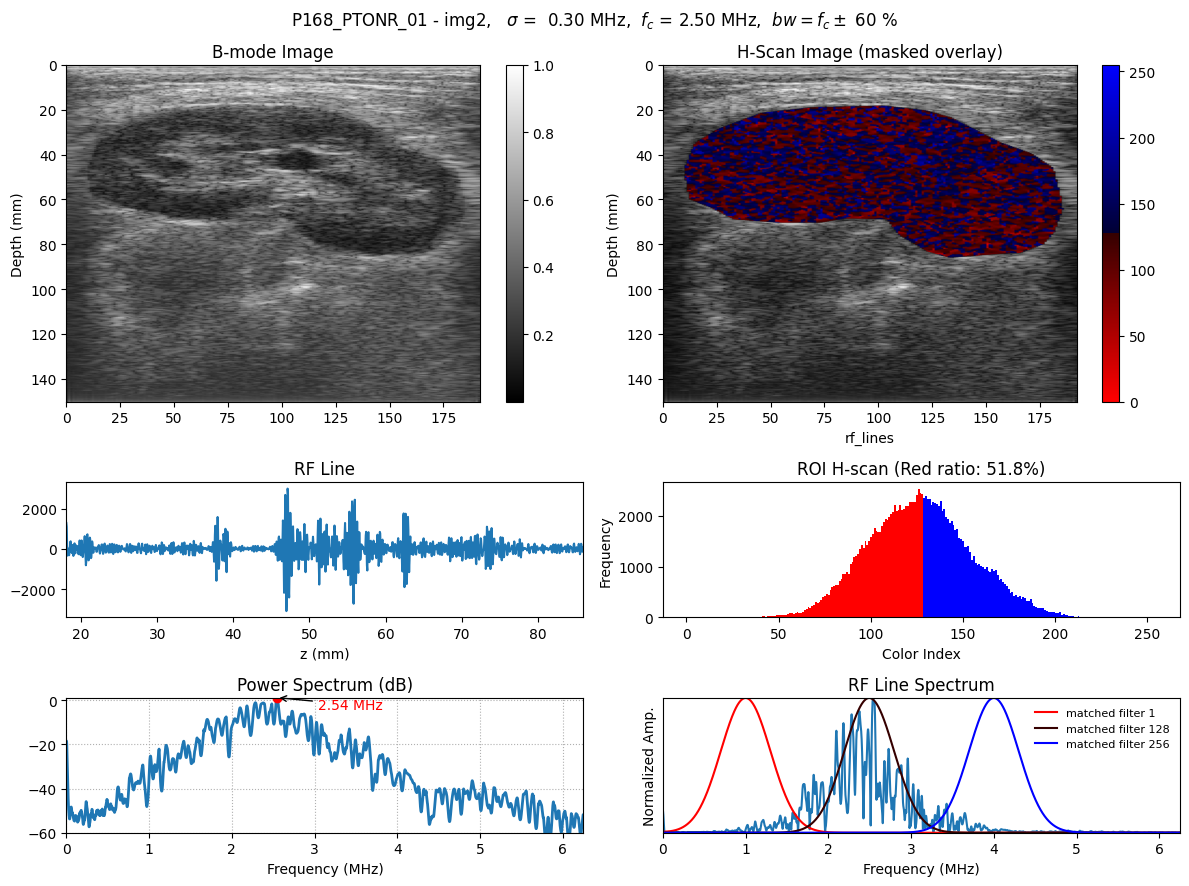

In [14]:
#This cell is maily for NON kidney data
# Mask the color_index with the ROI mask
masked_color_index = mask_nan(hscan_RR, mask_RR)
fm = np.linspace((1-bw_fc)*fc, (1+bw_fc)*fc, 256)


# Select the middle column of frame_rf_RR
mid_col = frame_rf_RR.shape[1] // 2
rf_line = frame_rf_RR[:, mid_col]

f, line_ft, db = signal_fft(rf_line, fs, Nfft, window_type='hamming')

if frequency_smoothnig:
    line_ft = smooth_spectrum(line_ft, FLT=FLT, WIN_LEN=WIN_LEN)

ff = 2.5e-6* fc  # Convert to MHz
# Smooth the power spectrum if needed
# Create the figure and the GridSpec layout
fig1 = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.4,0.4])  # Adjusted layout to add a new row for the histogram

# First subplot: B-mode Image
ax1 = plt.subplot(gs[0, 0])
im1 = ax1.imshow(bmode, cmap='gray', aspect='auto',alpha=alpha_mask, extent=[0, bmode.shape[1], z.max(), z.min()])
ax1.set_title('B-mode Image')
#ax1.set_xlabel('rf_lines')
ax1.set_ylabel('Depth (mm)')
#ax1.grid(color='white', linestyle='--', linewidth=0.5)

# if ROI_RECT:
#     y1, y2, x1, x2 = RC
#     # Add the rectangle to ax1
#     roi_rect = patches.Rectangle((x1, z[y1]), x2 - x1, z[y2] - z[y1], facecolor='none', linewidth=1, edgecolor='yellow', linestyle='--')
#     ax1.add_patch(roi_rect)
    
fig1.colorbar(im1, ax=ax1)

# #########
# # Second subplot: H-scan overlay on B-mode (ROI)
# axes[1].imshow(bmode, cmap='gray', aspect='auto', extent=[0, bmode.shape[1], z.max(), z.min()])
# im = axes[1].imshow(
#     hscan_RR,
#     alpha=alpha_mask_RR,
#     cmap=hscan,
#     aspect='auto',
#     extent=[x1, x2, z[y2], z[y1]]
# )
# axes[1].set_title('H-scan Overlay on B-mode (ROI)')
# axes[1].set_xlabel('Line')
# axes[1].set_ylabel('Depth (mm)')
# axes[1].set_ylim(z.max(), z.min())
# axes[1].set_xlim(0, bmode.shape[1])
# plt.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()

# #########
# Second subplot: Color Index
ax2 = plt.subplot(gs[0, 1])
# Overlay color_index where mask==1 on top of bmode
#plt.imshow(color_index, cmap=hscan, aspect='auto', extent=[0, bmode.shape[1], z.max(), z.min()])
ax2.imshow(bmode, cmap='gray', aspect='auto', extent=[0, bmode.shape[1], z.max(), z.min()])
im2 = plt.imshow(hscan_overlay_masked, cmap=hscan, aspect='auto', vmin=0, vmax=255,
                 extent=[0, bmode.shape[1], z.max(), z.min()])

# im2 = plt.imshow(
#             hscan_RR,
#             alpha=alpha_mask_RR,
#             cmap=hscan,
#             aspect='auto',
#             extent=[x1, x2, z[y2], z[y1]]
#         )

# #masked_color = np.ma.masked_where(mask != 1, hscan_RR)
# im2_overlay = ax2.imshow(masked_color, aspect='auto', cmap=hscan, alpha=0.7, vmax=255, vmin=0, extent=[0, bmode.shape[1], z.max(), z.min()])
ax2.set_title('H-Scan Image (masked overlay)')
ax2.set_xlabel('rf_lines')
ax2.set_ylabel('Depth (mm)')
ax2.set_xlim(0, bmode.shape[1])
ax2.set_ylim(z.max(), z.min())
#ax2.grid(color='white', linestyle='--', linewidth=0.5)
fig1.colorbar(im2, ax=ax2)

#   subplot: RF Line
ax3 = plt.subplot(gs[1, 0])
ax3.plot(z[y1:y2],rf_line)
ax3.set_title('RF Line')
ax3.set_xlim(z[y1], z[y2])
ax3.set_xlabel('z (mm)')

# subplot: Histogram of Color Index
ax4 = plt.subplot(gs[1, 1])  # Spanning both columns
hist, bins = np.histogram(masked_color_index.flatten(), bins=256, range=(0, 255))
red_ratio = np.sum(hist[:128]) / np.sum(hist)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for bin_center, count in zip(bin_centers, hist):
    color = 'red' if bin_center < 128 else 'blue'
    ax4.bar(bin_center, count, color=color, width=1)
ax4.set_title(f'ROI H-scan (Red ratio: {100*red_ratio:.1f}%)')
ax4.set_xlabel('Color Index')
ax4.set_ylabel('Frequency')

amp = 1 # amplitude of the matched filter, just to scale the plot
# subplot: RF Line Spectrum
ax5 = plt.subplot(gs[2, 1])
ax5.plot(f*1e-6,(np.abs(ifftshift(line_ft))/np.max(np.abs(ifftshift(line_ft)))))

colors = [hscan(0), hscan(127 / 255), hscan(255 / 255)]
for i, n in enumerate([0, 127, 255]):
    matched_filter = gaussian_cos_filter(f, fm, sigma, n)
    ax5.plot(f * 1e-6, amp*fftshift(matched_filter), label=f'matched filter {n+1}', color=colors[i])

ax5.set_xlim(0,ff)
ax5.set_ylim(0, amp)
ax5.set_title('RF Line Spectrum') 
ax5.set_xlabel('Frequency (MHz)')
ax5.set_yticks([])
ax5.set_ylabel('Normalized Amp.')
ax5.legend(loc='upper right', fontsize=8, frameon=False)

# subplot: RF power Spectrum (dB)

#  # Compute the power
# power = smooth_spectrum(np.abs(line_ft) ** 2)
# power_db = 10 * np.log10(power/np.max(power))

ax6 = plt.subplot(gs[2, 0])
#xx6 = smooth_spectrum(ifftshift(db))#
xx6 = smooth_spectrum(ifftshift(db),WIN_LEN= 33)
ax6.plot(f * 1e-6, xx6, linewidth=2)
# Find the frequency corresponding to the maximum power in positive frequencies
positive_freqs = f > 0
max_power_idx = np.argmax(xx6[positive_freqs]) + np.where(positive_freqs)[0][0]
max_power_freq = f[max_power_idx] * 1e-6  # Convert to MHz
# Mark the maximum point with a red dot
ax6.plot(max_power_freq, xx6[max_power_idx], 'ro')
# Annotate the maximum point with its frequency value
ax6.annotate(f'{max_power_freq:.2f} MHz', 
             xy=(max_power_freq, xx6[max_power_idx]), 
             xytext=(max_power_freq + 0.5, xx6[max_power_idx] - 5), 
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=10, color='red')

ax6.set_title('Power Spectrum (dB)') 
ax6.set_xlabel('Frequency (MHz)')
ax6.set_xlim(0, ff)
ax6.set_ylim(-60, 1)
ax6.grid(True, linestyle=':', linewidth=0.8)

# Adjust layout and show the plot
plt.rcParams.update({'font.size': 10})

# Add vertical space
plt.subplots_adjust(hspace=0.3)  # Increase this number if needed

#Add a title to the entire figure
if isinstance(patient_id, (int, float)):
    fig1.suptitle(rf'P{patient_id}_{visit_type}_0{visit_id} - img{image_id},   $\sigma$ = {1e-6*sigma: .2f} MHz,  $f_c$ = {fc/1e6:.2f} MHz,  $bw = f_c \pm${100*bw_fc: .0f} %')
else:
    fig1.suptitle(rf'{patient_id},   $\sigma$ = {1e-6*sigma: .2f} MHz,  $f_c$ = {fc/1e6:.2f} MHz,  $bw = f_c \pm${100*bw_fc: .0f} %') 
plt.tight_layout()
plt.show()

In [11]:
base_file_name = rf'P{patient_id}_{visit_type}_0{visit_id}_Image{image_id}'
base_file_name

'P168_PTONR_01_Image2'

In [26]:
aa= hscan_RR.shape
aa[0]*aa[1]

232848

In [ ]:
f = (fftfreq(Nfft, d=1/fs))
sp = fft(frame_rf[:, LINE], n=Nfft)
fm = np.linspace((1-bw_fc)*fc, (1+bw_fc)*fc, 256)
gc = np.exp(- (f - fm[127])**2 / (2 * sigma**2)) + np.exp(- (f + fm[127])**2 / (2 * sigma**2))
plt.plot( np.abs(sp)/np.max(np.abs(sp)), label='RF Line Spectrum')
plt.plot ( (gc))


# Perpare Hscan for matlab

In [ ]:
import numpy as np
from scipy.signal import hilbert
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

def generate_hscan(frame_rf, fs=15e6, fc=2.5e6, bw_fc=0.6, sigma=0.3e6, N=256):
    """
    Generate H-Scan color index from RF data without using signal_fft or gaussian_cos_filter.
    All calculations are done from scratch inside this function.

    Parameters:
        frame_rf (numpy.ndarray): 2D array of RF data (samples x lines).
        fs (float): Sampling frequency in Hz.
        fc (float): Center frequency in Hz.
        bw_fc (float): Bandwidth fraction of the center frequency.
        sigma (float): Standard deviation for Gaussian filter in Hz.
        N (int): Number of filters to apply.

    Returns:
        numpy.ndarray: H-Scan color index (samples x lines, dtype=np.uint8).
    """

    samples, lines = frame_rf.shape
    Nfft = 2 ** int(np.ceil(np.log2(samples)))
    f = (fftfreq(Nfft, d=1/fs))
    fm = np.linspace((1-bw_fc)*fc, (1+bw_fc)*fc, N)

    color_index = np.zeros((samples, lines), dtype=np.uint8)

    for line in range(lines):
        rf_line = frame_rf[:, line]
        # Apply Hamming window before FFT
        window = np.hamming(len(rf_line))
        rf_line = rf_line * window
        
        # Compute the FFT of the RF line
        line_ft = fft(rf_line, n=Nfft)

        filtered_rf_line = np.zeros((samples, N))
        for n in range(N):
            gc = np.exp(- (f - fm[n])**2 / (2 * sigma**2)) + np.exp(- (f + fm[n])**2 / (2 * sigma**2))
            filtered_ft = line_ft * gc
    
            filtered_rf_line[:, n] = np.real(ifft(filtered_ft))[:samples]

        filtered_env_line = np.abs(hilbert(filtered_rf_line, axis=0))
        color_index[:, line] = np.argmax(filtered_env_line, axis=1).astype(np.uint8)

    return color_index

    